In [34]:
! pip install kaggle -q

## Import the dependencies

In [35]:
import os
import json
import string
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk#natural language toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Collection

In [36]:
kaggle_config = json.load(open("kaggle.json"))

In [37]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [38]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [39]:
#loading kaggle dataset using api
! kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
spotify-million-song-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
! ls
! unzip spotify-million-song-dataset.zip -d spotify-million-song-dataset

kaggle.json  spotify-million-song-dataset
sample_data  spotify-million-song-dataset.zip
Archive:  spotify-million-song-dataset.zip
replace spotify-million-song-dataset/spotify_millsongdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spotify-million-song-dataset/spotify_millsongdata.csv  


In [41]:
# load the dataset
df = pd.read_csv('spotify-million-song-dataset/spotify_millsongdata.csv')
df.head(5)

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [42]:
df.shape

(57650, 4)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [44]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [45]:
# top artist and song of our dataset
top_artists = df['artist'].value_counts().head(10)
top_songs = df['song'].value_counts().head(10)
print(top_artists,top_songs)

artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64 song
Have Yourself A Merry Little Christmas    35
Angel                                     28
Home                                      27
Hold On                                   27
I Believe                                 26
Crazy                                     25
Silent Night                              25
The Christmas Song                        25
Forever                                   25
I Love You                                22
Name: count, dtype: int64


In [46]:
df = df.sample(10000)

df = df.drop('link',axis = 1).reset_index(drop = True)

In [47]:
df

,artist,song,text
0,Rage Against The Machine,Darkness,Greed \r\nCausing innocent blood to flow \r\...
1,Demi Lovato,Got My Girls,[Verse:] \r\nYou think that you're so slick ...
2,Slayer,Disorder,War!!! \r\n \r\nOur government is fucked \r...
3,Owl City,Unbelievable,It's unbelievable \r\nThis is as good as it g...
4,Blur,Dan Abnormal,Meanie Leanie come on down \r\nCome and enter...
...,...,...,...
9995,Toto,Animal,"I never felt like this with someone, I never k..."
9996,Pet Shop Boys,I Want A Dog,"I want a dog, \r\nA Chihuahua \r\nWhen I get..."
9997,NOFX,Monosyllabic Girl,"I take her to the aquarium, she says shark \r..."
9998,Ace Of Base,Who Am I,I was born in the shadows \r\nUnder the Iberi...


In [48]:
all_lyrics = "".join(df['text'].dropna())
wordcloud = WordCloud(width = 800,height = 400,background_color='white').generate(all_lyrics)

### using WordCloud to visualize the common words in a lyrics


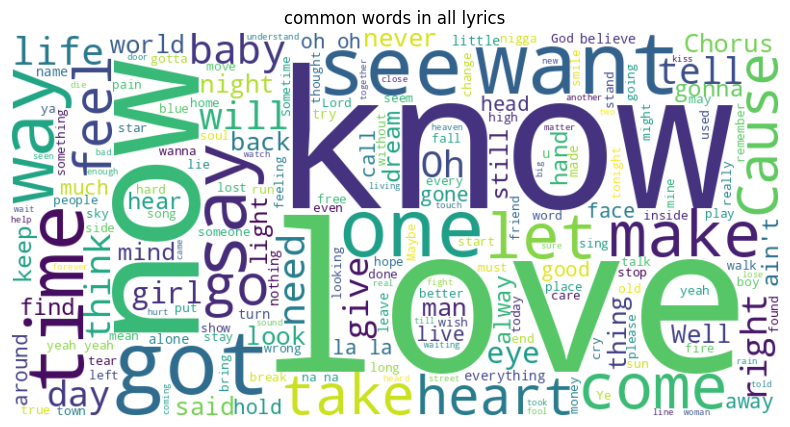

In [49]:
plt.figure(figsize = (10,5))
plt.imshow(wordcloud,interpolation = 'bilinear')#
plt.axis("off")
plt.title("common words in all lyrics")
plt.show()

## data preprocessing

In [50]:
#download the nltk kits
nltk.download('stopwords')
nltk.download('punkt_tab')#used for word tokenization
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
# a set of stopwords by removing the duplicated words
stop_words= set(stopwords.words('english'))
# stop_words

In [52]:
def preprocessing_text(text):
  #remove special characters and columns
  # text = re.sub("[%s]" % re.escape(string.punctuation),"",text)only for punctuation'
  text = re.sub(r"[^a-zA-Z\s]","",text)

  #lowercase conversion
  text = text.lower()

  #word tokenization
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  #seperating words with space as while fiting the model in tfidfVectorizer, each word is counted as a token, so if we combine all words as one, there will be no unique value so model will have no training
  return " ".join(tokens)

In [53]:
#apply changes to lyrics
df['cleaned_text'] = df['text'].apply(preprocessing_text)
df.head(10)

,artist,song,text,cleaned_text
0,Rage Against The Machine,Darkness,Greed \r\nCausing innocent blood to flow \r\...,greed causing innocent blood flow entire cultu...
1,Demi Lovato,Got My Girls,[Verse:] \r\nYou think that you're so slick ...,verse think youre slick got something hold tho...
2,Slayer,Disorder,War!!! \r\n \r\nOur government is fucked \r...,war government fucked sure bring us media inci...
3,Owl City,Unbelievable,It's unbelievable \r\nThis is as good as it g...,unbelievable good gets unbelievable dont know ...
4,Blur,Dan Abnormal,Meanie Leanie come on down \r\nCome and enter...,meanie leanie come come entertain town friday ...
5,Chris Rea,Stick It,The steel mill closes down tonight \r\nAs the...,steel mill closes tonight dying embers fade gu...
6,Yo La Tengo,Nothing But You And Me,"Well, I don't care what's wrong or right \r\n...",well dont care whats wrong right youre side wo...
7,Korn,Embrace,Blood is boring \r\nSleep is boring \r\nDon'...,blood boring sleep boring dont stop running im...
8,Willie Nelson,Both Sides Now,Bows and flows of angel hair \r\nIce cream ca...,bows flows angel hair ice cream castles air fe...
9,Bee Gees,Man For All Seasons,Everybody wants to leave \r\nJust like you an...,everybody wants leave like year smile tear eve...


In [54]:
# conversion of words to numbers
tdidf_vectorizer = TfidfVectorizer()
tdidf_matrix = tdidf_vectorizer.fit_transform(df['cleaned_text'])
tdidf_matrix[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 102 stored elements and shape (1, 38413)>

In [55]:
# compute cosine similarity
cos_similarity = cosine_similarity(tdidf_matrix,tdidf_matrix)
cos_similarity

array([[1.        , 0.01404909, 0.01109804, ..., 0.0167728 , 0.01411452,
        0.02121193],
       [0.01404909, 1.        , 0.01865782, ..., 0.01118188, 0.01567497,
        0.07515842],
       [0.01109804, 0.01865782, 1.        , ..., 0.00599878, 0.00499908,
        0.02245931],
       ...,
       [0.0167728 , 0.01118188, 0.00599878, ..., 1.        , 0.        ,
        0.00601606],
       [0.01411452, 0.01567497, 0.00499908, ..., 0.        , 1.        ,
        0.01824892],
       [0.02121193, 0.07515842, 0.02245931, ..., 0.00601606, 0.01824892,
        1.        ]])

## Recomendation function

In [56]:
def recommend_songs(song_name, cosine_sim = cos_similarity, df = df, top_n = 5):
  #find the index of the songs
  idx = df[df['song'].str.lower() == song_name.lower].index
  print(idx)
  if len(idx) == 0:
    return "Song not found in the dataset"

  idx = idx[0]

  #get similarity score
  sim_score = list(enumerate(cosine_sim[idx]))
  sim_score = sorted(sim_score,key = lambda x: x[1],reverse = True)
  sim_score = sim_score[1:top_n+1]

  #get song indices
  song_indices = [song[0] for song in sim_score]

  #return similar songs
  return df[['song','artist']].iloc[song_indices]

In [60]:
print(df['song'].unique())

['Darkness' 'Got My Girls' 'Disorder' ... 'Monosyllabic Girl' 'Who Am I'
 'Niggy Nuts']


In [61]:
recommend_songs('Darkness')

Index([], dtype='int64')


'Song not found in the dataset'